In [1]:
# Step 0: imports and seed
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

np.random.seed(42)


# Step 1: create 60 individuals split into 4 groups
n = 60
per_group = n // 4  # 15 each

groups = []
ages = []
avg_incomes = []
for group_idx in range(4):
    for i in range(per_group):
        if group_idx == 0:  # low income, young
            ages.append(int(np.random.normal(30, 3)))
            avg_incomes.append(int(np.random.normal(35000, 4000)))
            groups.append("low_young")
        elif group_idx == 1:  # low income, old
            ages.append(int(np.random.normal(60, 4)))
            avg_incomes.append(int(np.random.normal(34000, 4000)))
            groups.append("low_old")
        elif group_idx == 2:  # high income, young
            ages.append(int(np.random.normal(33, 3)))
            avg_incomes.append(int(np.random.normal(110000, 8000)))
            groups.append("high_young")
        else:  # high income, old
            ages.append(int(np.random.normal(62, 4)))
            avg_incomes.append(int(np.random.normal(115000, 8000)))
            groups.append("high_old")

df = pd.DataFrame(
    {"id": np.arange(n), "group": groups, "age": ages, "avg_income": avg_incomes}
)

df.head()


,id,group,age,avg_income
0,0,low_young,31,34446
1,1,low_young,31,41092
2,2,low_young,29,34063
3,3,low_young,34,38069
4,4,low_young,28,37170


In [ ]:

# ---- TRUE underlying parameters ----

# baseline group intercepts
true_intercept = {
    'low_young':  3.0,
    'low_old':    2.0,
    'high_young': 2.5,
    'high_old':   1.5
}

# group-specific rate sensitivity (strongly nonlinear)
def true_rate_effect(rate, group):
    if group == 'low_young':
        return -40 * rate - 200 * rate**2   # much stronger
    elif group == 'low_old':
        return -25 * rate - 120 * rate**2
    elif group == 'high_young':
        return -15 * rate - 80 * rate**2
    else:  # high_old
        return -8 * rate - 40 * rate**2

# coef_age = -0.02
# coef_income = 0.00002
# python
coef_age = -0.005
coef_income = 0.000005

# assign offered rates
df['offered_rate'] = np.round(np.random.uniform(0.00, 0.20, size=len(df)), 4)

# ---- TRUE logistic probability ----

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

probs = []
for i, row in df.iterrows():
    g = row['group']
    rate = row['offered_rate']
    
    linear = (
        true_intercept[g]
        + coef_age * row['age']
        + coef_income * row['avg_income']
        + true_rate_effect(rate, g)
    )
    
    p = sigmoid(linear)
    probs.append(p)

df['true_prob'] = probs
df['accepted'] = np.random.binomial(1, df['true_prob'])




In [ ]:


df[['id','group','age','avg_income','offered_rate','true_prob','accepted']].head()

,id,group,age,avg_income,offered_rate,true_prob,accepted
0,0,low_young,31,34446,0.0794,0.194718,0
1,1,low_young,31,41092,0.0102,0.932242,1
2,2,low_young,29,34063,0.1773,0.000032,0
3,3,low_young,34,38069,0.0055,0.942367,1
4,4,low_young,28,37170,0.1158,0.013815,0


In [12]:
# Step 4: prepare features with group one-hot and rate×group interactions
X_base = df[['age','avg_income','offered_rate']].copy()
group_dummies = pd.get_dummies(df['group'], prefix='grp')
X = pd.concat([X_base, group_dummies], axis=1)

# add explicit interaction columns: rate * each group dummy
for col in group_dummies.columns:
    X[f'{col}_x_rate'] = X['offered_rate'] * X[col]

y = df['accepted']

# Fit logistic regression
model = LogisticRegression(solver='liblinear', max_iter=1000)
model.fit(X, y)

# show coefficients
coef_names = X.columns.tolist()
coefs = pd.Series(np.concatenate([model.intercept_, model.coef_.ravel()]), 
                  index=['intercept'] + coef_names)
print(coefs.round(6))

intercept               -0.000810
age                     -0.030791
avg_income               0.000025
offered_rate            -0.000372
grp_high_old             0.000342
grp_high_young          -0.000013
grp_low_old             -0.000569
grp_low_young           -0.000570
grp_high_old_x_rate     -0.000009
grp_high_young_x_rate   -0.000071
grp_low_old_x_rate      -0.000138
grp_low_young_x_rate    -0.000155
dtype: float64


In [13]:
# Step 5: helper to build features for a given individual and a given rate value (for the fitted model)
def build_feature_row(age, avg_income, rate, group):
    base = {'age': age, 'avg_income': avg_income, 'offered_rate': rate}
    grp_vals = {c: 1 if c == f'grp_{group}' else 0 for c in group_dummies.columns}
    row = {**base, **grp_vals}
    # add interactions
    for col in group_dummies.columns:
        row[f'{col}_x_rate'] = row['offered_rate'] * row[col]
    # preserve column order
    return [row[c] for c in coef_names]

# rates grid to evaluate
rates = np.linspace(0.0, 0.20, 201)  # 0% to 20%
prob_curves = []

for i, row in df.iterrows():
    feature_rows = [build_feature_row(row['age'], row['avg_income'], r, row['group']) for r in rates]
    probs = model.predict_proba(feature_rows)[:,1]
    prob_curves.append(probs)

# attach to dataframe for later use
df['prob_curve'] = prob_curves


/Users/sayantanauddy/Documents/Work/TD_work/exp_env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/Users/sayantanauddy/Documents/Work/TD_work/exp_env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/Users/sayantanauddy/Documents/Work/TD_work/exp_env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/Users/sayantanauddy/Documents/Work/TD_work/exp_env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/Users/sayantanauddy/Documents/Work/TD_work/exp_env/lib/pyth

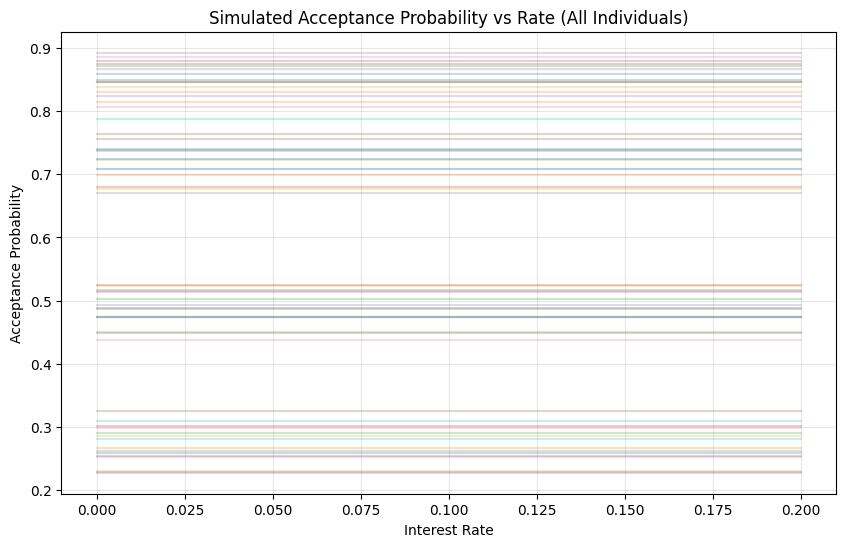

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

for probs in df['prob_curve']:
    plt.plot(rates, probs, alpha=0.25)

plt.xlabel("Interest Rate")
plt.ylabel("Acceptance Probability")
plt.title("Simulated Acceptance Probability vs Rate (All Individuals)")
plt.grid(True, alpha=0.3)
plt.show()










In [7]:
# Debug 1: feature names and coefficients
print("Number of features expected:", len(coef_names))
print("Feature names (coef_names):", coef_names)
print("Intercept:", model.intercept_)
print("Coefficients:", model.coef_.ravel())

Number of features expected: 11
Feature names (coef_names): ['age', 'avg_income', 'offered_rate', 'grp_high_old', 'grp_high_young', 'grp_low_old', 'grp_low_young', 'grp_high_old_x_rate', 'grp_high_young_x_rate', 'grp_low_old_x_rate', 'grp_low_young_x_rate']
Intercept: [0.00012315]
Coefficients: [-5.92583461e-03  3.59590738e-05  6.11623592e-06  6.84855447e-05
 -9.92728224e-05 -3.45899141e-04  4.99836876e-04  4.12054296e-06
  9.02917250e-07 -3.16218981e-05  3.27146738e-05]


In [8]:
# pick an index to inspect
i = 0
row = df.loc[i]

# build a small sample of feature rows using your build_feature_row function
sample_rates = [0.0, 0.05, 0.10, 0.15]
sample_rows = [build_feature_row(row['age'], row['avg_income'], r, row['group']) for r in sample_rates]

# turn into DataFrame using coef_names to check column order/values
sample_df = pd.DataFrame(sample_rows, columns=coef_names)
sample_df['rate_input'] = sample_rates
print(sample_df)

   age  avg_income  offered_rate  grp_high_old  grp_high_young  grp_low_old  \
0   31       34446          0.00             0               0            0   
1   31       34446          0.05             0               0            0   
2   31       34446          0.10             0               0            0   
3   31       34446          0.15             0               0            0   

   grp_low_young  grp_high_old_x_rate  grp_high_young_x_rate  \
0              1                  0.0                    0.0   
1              1                  0.0                    0.0   
2              1                  0.0                    0.0   
3              1                  0.0                    0.0   

   grp_low_old_x_rate  grp_low_young_x_rate  rate_input  
0                 0.0                  0.00        0.00  
1                 0.0                  0.05        0.05  
2                 0.0                  0.10        0.10  
3                 0.0                  0.15        

In [9]:
# Debug 3: predict with DataFrame and print probabilities
probs = model.predict_proba(sample_df[coef_names])[:,1]
for r, p in zip(sample_rates, probs):
    print(f"rate={r:.3f} -> prob={p:.4f}")

rate=0.000 -> prob=0.7418
rate=0.050 -> prob=0.7418
rate=0.100 -> prob=0.7418
rate=0.150 -> prob=0.7418


20 20


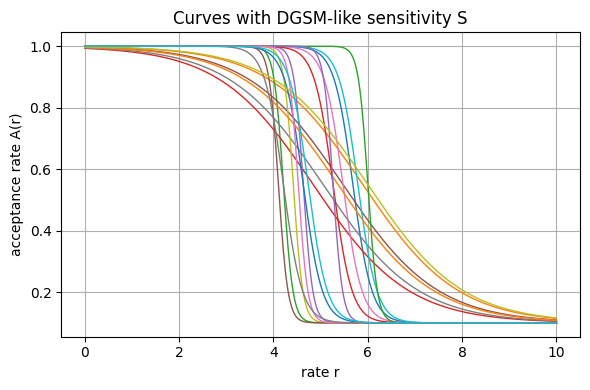

Average squared derivative S for each curve:
beta=5.00 & R0= 5.68 -> S=6.7455e-02
beta=1.00 & R0= 5.89 -> S=1.3489e-02
beta=10.00 & R0= 4.21 -> S=1.3464e-01
beta=1.00 & R0= 4.84 -> S=1.3496e-02
beta=10.00 & R0= 4.63 -> S=1.3464e-01
beta=1.00 & R0= 5.47 -> S=1.3494e-02
beta=5.00 & R0= 5.47 -> S=6.7455e-02
beta=1.00 & R0= 5.05 -> S=1.3496e-02
beta=10.00 & R0= 4.42 -> S=1.3464e-01
beta=5.00 & R0= 5.79 -> S=6.7455e-02
beta=5.00 & R0= 4.63 -> S=6.7455e-02
beta=1.00 & R0= 5.37 -> S=1.3495e-02
beta=10.00 & R0= 6.00 -> S=1.3464e-01
beta=5.00 & R0= 5.26 -> S=6.7455e-02
beta=10.00 & R0= 5.26 -> S=1.3464e-01
beta=10.00 & R0= 4.11 -> S=1.3464e-01
beta=10.00 & R0= 4.53 -> S=1.3464e-01
beta=5.00 & R0= 4.21 -> S=6.7455e-02
beta=1.00 & R0= 6.00 -> S=1.3486e-02
beta=5.00 & R0= 4.74 -> S=6.7455e-02


In [22]:
import numpy as np
import matplotlib.pyplot as plt

def avg_squared_derivative(r, A_vals):
    """
    Compute S = 1/(r_max - r_min) * ∫ (dA/dr)^2 dr
    for a single curve A(r) given on grid r.
    """
    r = np.asarray(r)
    A_vals = np.asarray(A_vals)

    # Numerical derivative dA/dr using central differences via np.gradient
    dA_dr = np.gradient(A_vals, r)

    # Squared derivative
    dA_dr_sq = dA_dr**2

    # Integral of (dA/dr)^2 over r using trapezoidal rule
    integral = np.trapezoid(dA_dr_sq, r)

    # Normalize by interval length
    S = integral / (r[-1] - r[0])
    return S


# Parameter grids
betas        = [1,5,10] # np.linspace(1.0, 20.0, 5)
r0_logistics = np.linspace(4.0, 6.0, 20)

# All 4×20 combinations
B, R0 = np.meshgrid(betas, r0_logistics, indexing="ij")
pairs = np.column_stack([B.ravel(), R0.ravel()])  # shape (80, 2)

# Shuffle the 100 pairs
idx = np.random.permutation(pairs.shape[0])
pairs_shuffled = pairs[idx]

# Example: take first 10 random combinations
betas_mixed        = pairs_shuffled[:20, 0]
r0_logistics_mixed = pairs_shuffled[:20, 1]

print(len(betas_mixed), len(r0_logistics_mixed))

A_maxs       = np.linspace(1.0, 1.0, 20)
A_mins       = np.linspace(0.1, 0.1, 20)

sensitivities = []

def A_logistic(r, beta, r0_logistic, A_min, A_max):
    """Smooth decreasing logistic."""
    r = np.asarray(r)
    return A_min + (A_max - A_min) / (1 + np.exp(beta * (r - r0_logistic)))

# Grid of r values
r = np.linspace(0, 10, 500)

plt.figure(figsize=(6, 4))

# IMPORTANT: use different variable names in the loop (no shadowing of arrays)
for b, r0, Amin, Amax in zip(betas_mixed, r0_logistics_mixed, A_mins, A_maxs):
    y_log = A_logistic(r, b, r0, Amin, Amax)
    S = avg_squared_derivative(r, y_log)
    sensitivities.append(S)
    plt.plot(r, y_log,  label=f"beta={b:.2f}, S={S:.3e}", linewidth=1)

plt.xlabel("rate r")
plt.ylabel("acceptance rate A(r)")
plt.title("Curves with DGSM-like sensitivity S")
plt.grid(True)
plt.tight_layout()
# plt.legend(fontsize=6)
plt.show()

# sensitivities now holds one scalar S per curve
print("Average squared derivative S for each curve:")
for b,r0, S in zip(betas_mixed, r0_logistics_mixed, sensitivities):
    print(f"beta={b:.2f} & R0= {r0:.2f} -> S={S:.4e}")


corr(S, beta) = nan
corr(S, r0)   = -0.000


/Users/sayantanauddy/Documents/Work/TD_work/exp_env/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/sayantanauddy/Documents/Work/TD_work/exp_env/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3066: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


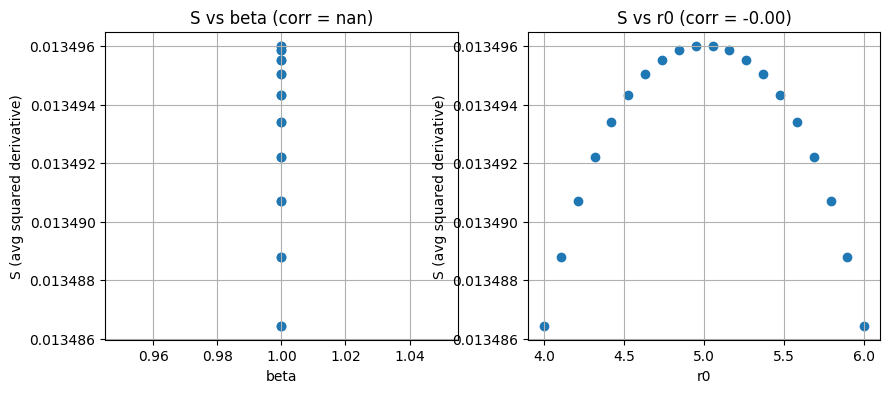

In [17]:
betas_mixed, r0_logistics_mixed, sensitivities
# Correlations
corr_S_beta = np.corrcoef(sensitivities, betas_mixed)[0, 1]
corr_S_r0   = np.corrcoef(sensitivities, r0_logistics_mixed)[0, 1]

print(f"corr(S, beta) = {corr_S_beta:.3f}")
print(f"corr(S, r0)   = {corr_S_r0:.3f}")

# Scatter plots
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.scatter(betas_mixed, sensitivities)
plt.xlabel("beta")
plt.ylabel("S (avg squared derivative)")
plt.title(f"S vs beta (corr = {corr_S_beta:.2f})")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.scatter(r0_logistics_mixed, sensitivities)
plt.xlabel("r0")
plt.ylabel("S (avg squared derivative)")
plt.title(f"S vs r0 (corr = {corr_S_r0:.2f})")
plt.grid(True)
